# Project 4 Modeling 

**Authors: Scott Rosengrants, Megha Zavar**

In [119]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from  sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import seaborn as sns

/Users/scottrosengrants/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [61]:
#read in data
train_wage = pd.read_csv("./data/train_clean.csv")
test_wage  = pd.read_csv("./data/test_clean.csv")

In [62]:
test_wage.columns

Index(['age', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-gain',
       'capital-loss', 'hours-per-week', 'native-country',
       'workclass_Local-gov', 'workclass_Never-worked', 'workclass_Private',
       'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc',
       'workclass_State-gov', 'workclass_Unknown', 'workclass_Without-pay',
       'marital-status_Married-AF-spouse', 'marital-status_Married-civ-spouse',
       'marital-status_Married-spouse-absent', 'marital-status_Never-married',
       'marital-status_Separated', 'marital-status_Widowed',
       'occupation_Armed-Forces', 'occupation_Craft-repair',
       'occupation_Exec-managerial', 'occupation_Farming-fishing',
       'occupation_Handlers-cleaners', 'occupation_Machine-op-inspct',
       'occupation_Other-service', 'occupation_Priv-house-serv',
       'occupation_Prof-specialty', 'occupation_Protective-serv',
       'occupation_Sales', 'occupation_Tech-support',
       'occupation_Transport-moving', 'oc

In [180]:
#set features and target
X = train_wage.drop(columns =['wage','relationship'])
y = train_wage['wage']

In [181]:
# split data for modeling
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify =y)

In [65]:
#Evaluate Baseline for train
y_train.value_counts(normalize=True)

0    0.759173
1    0.240827
Name: wage, dtype: float64

In [66]:
#Evaluate Baseline for test
y_test.value_counts(normalize=True)

0    0.759243
1    0.240757
Name: wage, dtype: float64

In [67]:
# Instantiate Random Forrest Model
md = RandomForestClassifier(random_state=42)
md.fit(X_train,y_train)

/Users/scottrosengrants/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [68]:
# Check the train and test accuracy scores based on the default settings for Random Forrest
md.score(X_train,y_train),md.score(X_test,y_test)

(0.9863226863226863, 0.8346640461859722)

In [70]:
y_train_pred = md.predict(X_train)

In [71]:
y_train_pred

array([0, 1, 1, ..., 0, 0, 0])

In [72]:
predict_1 =md.predict_proba(X_train)[: ,1]

In [73]:
results = pd.DataFrame()
results['true_values'] = y_train
results['predictions'] =y_train_pred
results['pred_probs'] = predict_1


In [74]:
# display results
results

,true_values,predictions,pred_probs
11344,0,0,0.0
22301,1,1,0.7
7499,1,1,0.9
10171,1,1,0.9
25545,0,0,0.1
...,...,...,...
15354,0,0,0.0
23923,0,0,0.0
8020,0,0,0.0
28101,0,0,0.2


In [75]:
#create a confusion matrix
cmetrix = pd.crosstab(results['true_values'],results['predictions'],rownames=[True] ,colnames=['predicted'],margins=True)
cmetrix  = cmetrix.rename(columns= {0 : '-ve' , 1 : ' +ve'},index={0 : '-ve' , 1 : ' +ve'})
cmetrix

True,-ve,+ve,All
predicted,,,
-ve,18493,288,18539
+ve,46,5593,5881
All,18781,5639,24420


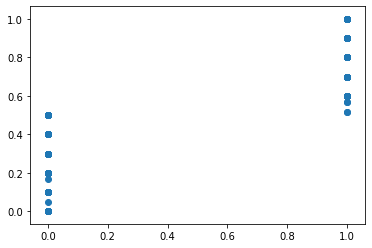

In [76]:
#plot predictions and prediction probabilities
plt.scatter(results['predictions'],results['pred_probs'] )

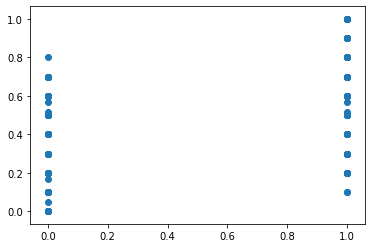

In [77]:
# plot true values and prediction probabilities
plt.scatter(results['true_values'],results['pred_probs'] )

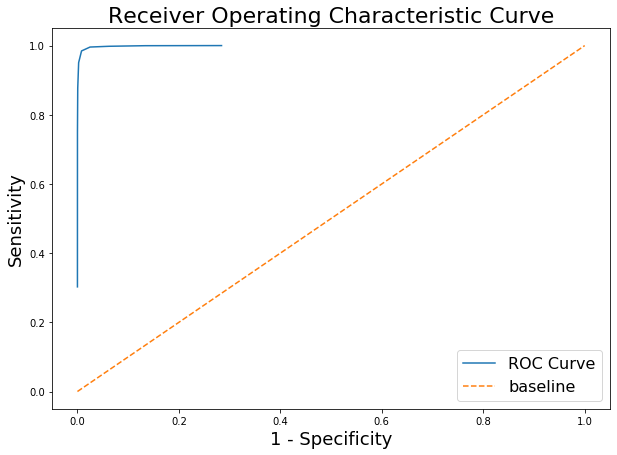

In [78]:
#Plot the ROC curve

# Create figure.
plt.figure(figsize = (10,7))
# Create threshold values.
thresholds = np.linspace(0, 1, 200)
# Define function to calculate sensitivity. (True positive rate.)

def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))

# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(results, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(results, 'true_values', 'pred_probs', prob) for prob in thresholds]
# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')
# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')
# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)
# Create legend.
plt.legend(fontsize=16);

# Prediction for real test dataset 
(used to create the submission csv)

In [175]:
test_features = test_wage[small_list]

In [176]:
def predict_classifier(md,X ):
    predictions_comp = md.predict(X)
    predict_1 =md.predict_proba(X)[: ,1]
    df = pd.DataFrame(predict_1, columns=['wage'])
    
    return df

In [177]:
submission_df = predict_classifier(gs , test_features)

In [178]:
submission_df.to_csv("./data/submission_sm.csv" ,index=False)

## Model Optimization using Gridsearch

In [182]:
#Model #1
#create params 
rf_params = {
    'n_estimators' : [100, 150, 200],
    'max_depth' : [None, 10, 5]
        
}

#create grid search
gs = GridSearchCV(md,rf_params, cv = 5)
gs.fit(X_train,y_train)

print(f'Best params: {gs.best_params_}')
print(f'Best score: {np.round(gs.best_score_,4)}')
print(f'Test score {np.round(gs.score(X_test,y_test),4)}')

Best params: {'max_depth': 10, 'n_estimators': 200}
Best score: 0.8452
Test score 0.8388


In [183]:
#Model #2
#create params 
rf_params = {
    'n_estimators' : [200,300,400],
    'max_depth' : [7,10,20]
        
}

#create grid search
gs = GridSearchCV(md,rf_params, cv = 5)
gs.fit(X_train,y_train)

print(f'Best params: {gs.best_params_}')
print(f'Best score: {np.round(gs.best_score_,4)}')
print(f'Test score {np.round(gs.score(X_test,y_test),4)}')

Best params: {'max_depth': 20, 'n_estimators': 400}
Best score: 0.8472
Test score 0.8413


In [184]:
#Model #3
#create params 
rf_params = {
    'n_estimators' : [200],
    'max_depth' : [10], #optimized
    'criterion' : ['gini', 'entropy']
        
}

#create grid search
gs = GridSearchCV(md,rf_params, cv = 5)
gs.fit(X_train,y_train)

print(f'Best params: {gs.best_params_}')
print(f'Best score: {np.round(gs.best_score_,4)}')
print(f'Test score {np.round(gs.score(X_test,y_test),4)}')

Best params: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 200}
Best score: 0.8452
Test score 0.8388


In [185]:
#Model #4
#create params 
rf_params = {
    'n_estimators' : [200],
    'max_depth' : [10], #optimized
    'criterion' : ['gini'], #optimized
    'max_features' : ['auto','sqrt']
        
}

#create grid search
gs = GridSearchCV(md,rf_params, cv = 5)
gs.fit(X_train,y_train)

print(f'Best params: {gs.best_params_}')
print(f'Best score: {np.round(gs.best_score_,4)}')
print(f'Test score {np.round(gs.score(X_test,y_test),4)}')

Best params: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 200}
Best score: 0.8452
Test score 0.8388


In [186]:
#Model #5
#create params 
rf_params = {
    'n_estimators' : [200],
    'max_depth' : [10], #optimized
    'criterion' : ['gini'], #optimized
    'max_features' : ['auto'], #optimized
    'min_samples_split' : [2,5,10],
    'min_samples_leaf' :[1,2,4]
         
}

#create grid search
gs = GridSearchCV(md,rf_params, cv = 5)
gs.fit(X_train,y_train)

print(f'Best params: {gs.best_params_}')
print(f'Best score: {np.round(gs.best_score_,4)}')
print(f'Test score {np.round(gs.score(X_test,y_test),4)}')

Best params: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best score: 0.8452
Test score 0.8388


In [187]:
#Model #6
#create params 
rf_params = {
    'n_estimators' : [200],
    'max_depth' : [10], #optimized
    'criterion' : ['gini'], #optimized
    'max_features' : ['auto'], #optimized
    'min_samples_split' : [2],
    'min_samples_leaf' :[1],
    'bootstrap' :[True, False],
    
         
}

#create grid search
gs = GridSearchCV(md,rf_params, cv = 5)
gs.fit(X_train,y_train)

print(f'Best params: {gs.best_params_}')
print(f'Best score: {np.round(gs.best_score_,4)}')
print(f'Test score {np.round(gs.score(X_test,y_test),4)}')

Best params: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best score: 0.8452
Test score 0.8388


In [188]:
#Model #7
#create params 
rf_params = {
    'n_estimators' : [200],
    'max_depth' : [10], #optimized
    'criterion' : ['gini'], #optimized
    'max_features' : ['auto', None, 'log2'], 
    'min_samples_split' : [2], #optimized
    'min_samples_leaf' :[1], #optimized
    'bootstrap' :[True], #optimized
    
         
}

#create grid search
gs = GridSearchCV(md,rf_params, cv = 5)
gs.fit(X_train,y_train)

print(f'Best params: {gs.best_params_}')
print(f'Best score: {np.round(gs.best_score_,4)}')
print(f'Test score {np.round(gs.score(X_test,y_test),4)}')

Best params: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best score: 0.8452
Test score 0.8388


In [189]:
#Model #8 added 'fnlwgt' as a feature
#create params 
rf_params = {
    'n_estimators' : [200],
    'max_depth' : [10], #optimized
    'criterion' : ['gini'], #optimized
    'max_features' : ['auto'], #optimized
    'min_samples_split' : [2], #optimized
    'min_samples_leaf' :[1], #optimized
    'bootstrap' :[True], #optimized
    
    
         
}

#create grid search
gs = GridSearchCV(md,rf_params, cv = 5)
gs.fit(X_train,y_train)

print(f'Best params: {gs.best_params_}')
print(f'Best score: {np.round(gs.best_score_,4)}')
print(f'Test score {np.round(gs.score(X_test,y_test),4)}')

Best params: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best score: 0.8452
Test score 0.8388


In [190]:
#Model #8.1 added 'fnlwgt'
#create params 
rf_params = {
    'n_estimators' : [1000],
    'max_depth' : [10], #optimized
    'max_features' : ['auto'], #optimized
    'min_samples_split' : [2], #optimized
    'min_samples_leaf' :[1], #optimized
    'bootstrap' :[True], #optimized
    
       
}

#create grid search
gs = GridSearchCV(md,rf_params, cv = 5)
gs.fit(X_train,y_train)

print(f'Best params: {gs.best_params_}')
print(f'Best score: {np.round(gs.best_score_,4)}')
print(f'Test score {np.round(gs.score(X_test,y_test),4)}')

Best params: {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
Best score: 0.8453
Test score 0.8396


In [191]:
#Model #9 feature selection
#create params 
rf_params = {
    'n_estimators' : [200],
    'max_depth' : [10], #optimized
    'max_features' : ['auto'], #optimized
    'min_samples_split' : [2], #optimized
    'min_samples_leaf' :[1], #optimized
    'bootstrap' :[True], #optimized
    
       
}

#create grid search
gs = GridSearchCV(md,rf_params, cv = 5)
gs.fit(X_train,y_train)

print(f'Best params: {gs.best_params_}')
print(f'Best score: {np.round(gs.best_score_,4)}')
print(f'Test score {np.round(gs.score(X_test,y_test),4)}')

Best params: {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best score: 0.8452
Test score 0.8388


In [192]:
#Model #10 feature selection
#create params 
rf_params = {
    'n_estimators' : [200],
    'max_depth' : [10], #optimized
    'max_features' : ['auto'], #optimized
    'min_samples_split' : [2], #optimized
    'min_samples_leaf' :[1], #optimized
    'bootstrap' :[True], #optimized
    
       
}

#create grid search
gs = GridSearchCV(md,rf_params, cv = 5)
gs.fit(X_train,y_train)

print(f'Best params: {gs.best_params_}')
print(f'Best score: {np.round(gs.best_score_,4)}')
print(f'Test score {np.round(gs.score(X_test,y_test),4)}')

Best params: {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best score: 0.8452
Test score 0.8388


### Feature Selection and test on best model

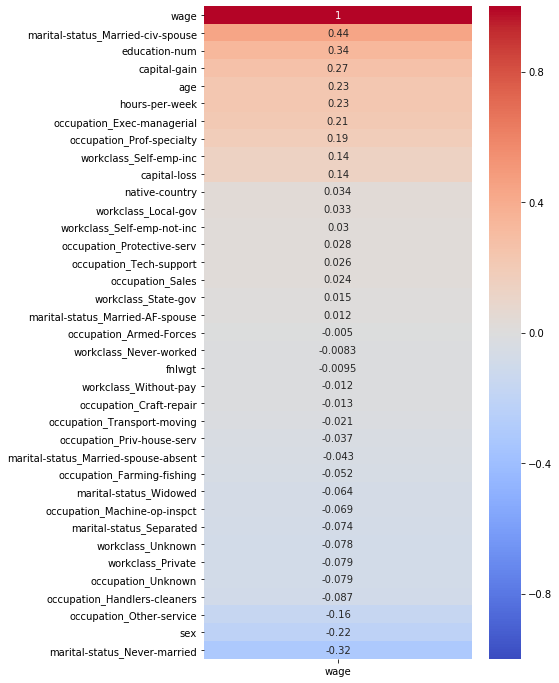

In [193]:
#view the correlation of all features as they relate to the target
feature_core = train_wage.corr()[['wage']].sort_values(by='wage',ascending=False)
plt.figure(figsize=(6,12))  # 6 by 12 inch to make plot bigger
sns.heatmap(feature_core, vmin=-1,vmax=1,cmap='coolwarm',annot=True)

In [194]:
# filter the features down to only those with a stron correlation
small_features = feature_core[(feature_core['wage'] > .1) | (feature_core['wage'] < -.1)]

In [195]:
small_features.drop(index = 'wage' , inplace=True)

/Users/scottrosengrants/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [196]:
#create a features list
small_list = list(small_features.index)

In [197]:
#view list
small_list

['marital-status_Married-civ-spouse',
 'education-num',
 'capital-gain',
 'age',
 'hours-per-week',
 'occupation_Exec-managerial',
 'occupation_Prof-specialty',
 'workclass_Self-emp-inc',
 'capital-loss',
 'occupation_Other-service',
 'sex',
 'marital-status_Never-married']

In [198]:
# recreate the X and y variables using new features
X = train_wage[small_list]
y = train_wage['wage']

In [199]:
#split data
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify =y)

In [200]:
# run best optimized model #9 using the new (smaller) features set

#create params 
rf_params = {
    'n_estimators' : [200],
    'max_depth' : [10], #optimized
    'max_features' : ['auto'], #optimized
    'min_samples_split' : [2], #optimized
    'min_samples_leaf' :[1], #optimized
    'bootstrap' :[True], #optimized
    
       
}

#create grid search
gs = GridSearchCV(md,rf_params, cv = 5)
gs.fit(X_train,y_train)

print(f'Best params: {gs.best_params_}')
print(f'Best score: {np.round(gs.best_score_,4)}')
print(f'Test score {np.round(gs.score(X_test,y_test),4)}')

Best params: {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best score: 0.8434
Test score 0.8449


#### The new simpler and smaller features list when paired with the optimized Random Forrest  performed the best and had the highest accuracy score out of all the attempts. Its test accuracy was also higher than the train accuracy indicating the Random Forrest is no longer overfit. 